In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime

In [2]:
data = pd.read_csv("A:/Programming/Python/NLP/Data files/Time_serires_analysis_data/AirPassengers.csv")
data.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [4]:
data['Month'] = pd.to_datetime(data.Month)
data = data.set_index(data.Month)
data.drop('Month', axis=1, inplace=True)

In [5]:
data.head(10)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [7]:
data.dtypes

#Passengers    int64
dtype: object

In [10]:
ts = data['#Passengers']
ts.head(144)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, Length: 144, dtype: int64

In [12]:
ts['1960']

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, dtype: int64

In [13]:
rcParams['figure.figsize'] = 15, 6

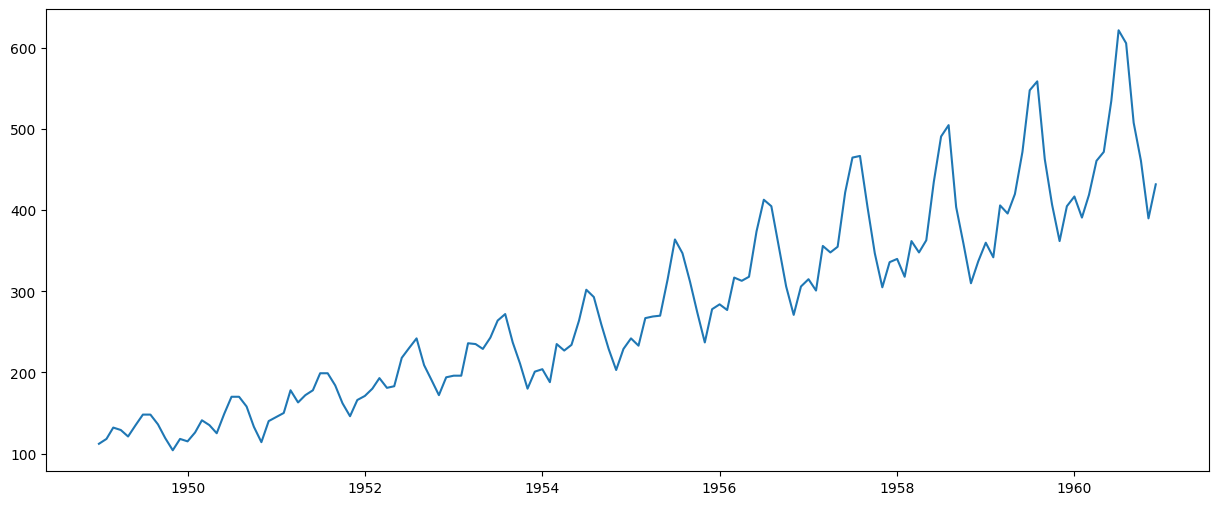

In [14]:
plt.plot(ts)

<Axes: ylabel='Density'>

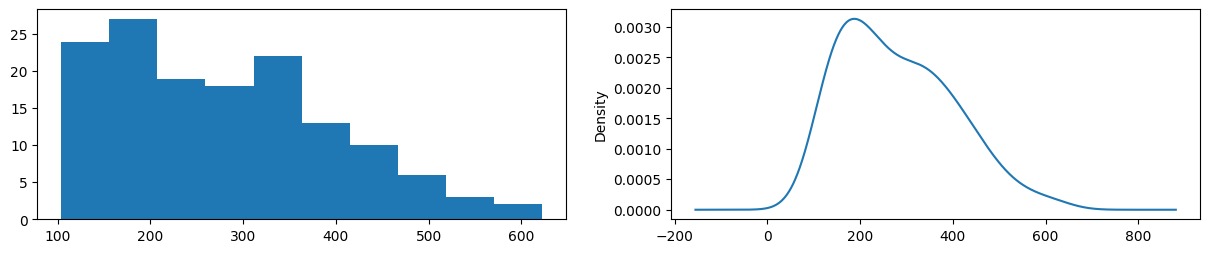

In [15]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind='kde')